In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

## Get census tracts file, use to trim the other file to the San Fran area of interest
from: https://hub.arcgis.com/datasets/MTC::san-francisco-bay-region-2020-census-tracts-clipped/about?uiVersion=content-views

In [5]:
census_tracts =  gpd.read_file('../../../data/SpatialData/SanFran/Census_2020_Tracts_SanFran/Census_Tracts_SanFran_2020.shp')
census_tracts = census_tracts.sort_values(by='tractce')
census_tracts = census_tracts[census_tracts['tractce']!='980401']

### Import classifications gpkg file
from: https://github.com/urban-displacement/displacement-typologies/blob/main/data/downloads_for_public/sanfrancisco.gpkg

In [9]:
gdf = gpd.read_file("../../../data/SpatialData/SanFran/GentrificationIndex_SpatialDomain.s")

# Clip tracts to Bay Area
gdf_bay = gpd.clip(gdf, census_tracts)

gdf_bay = gdf_bay[gdf_bay.geometry.type == 'Polygon']

gdf_bay['GEOID'] = gdf_bay['GEOID'].astype(int)
gdf_bay['GEOID'] = gdf_bay['GEOID'].astype(str)

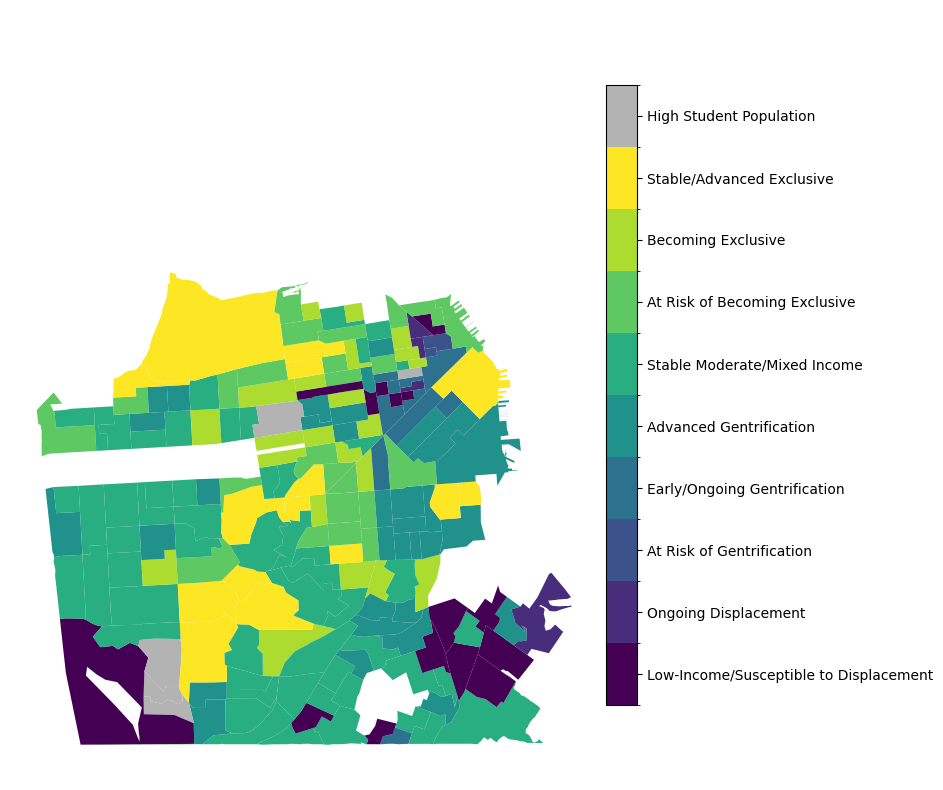

In [10]:
viridis = plt.get_cmap('viridis', 9)
viridis_colors = viridis(np.arange(9))
custom_colors = np.vstack([viridis_colors, [0.7, 0.7, 0.7, 1]])  # add gray
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set up a BoundaryNorm for discrete mapping (edges between each code)
bounds = np.arange(-0.5, 10.5, 1)  # 10 bins for values 0–9
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
p0 = gdf_bay.plot(column='Type_code',cmap=custom_cmap,norm=norm, ax=ax)

# Add colorbar with correct ticks and labels
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  # required for matplotlib < 3.1
cb0 = fig.colorbar(sm, ax=ax, ticks=np.arange(10), fraction=0.04, pad=0.01)
# cb0.set_label("Type_code")
cb0.ax.set_yticklabels(list(mapping.keys()))  # Optional: use labels instead of numbers

ax.axis('off')
plt.show()


### Creating smaller groups

In [92]:
alternate_mapping = {'Low-Income/Susceptible to Displacement': 0,'Ongoing Displacement':0, 'At Risk of Gentrification': 1, 
           'Early/Ongoing Gentrification': 2, 'Advanced Gentrification': 3, 'Stable Moderate/Mixed Income':3,
          'At Risk of Becoming Exclusive':4, 'Becoming Exclusive':4, 'Stable/Advanced Exclusive':4, 'High Student Population':5}

gdf_bay['Type_code_alternate'] = gdf_bay['Typology'].map(alternate_mapping)

In [ ]:
alternate_mapping = {'Low-Income/Susceptible to Displacement': 0,'Ongoing Displacement':0, 'At Risk of Gentrification': 1, 
           'Early/Ongoing Gentrification': 2, 'Advanced Gentrification': 3, 'Stable Moderate/Mixed Income':3,
          'At Risk of Becoming Exclusive':4, 'Becoming Exclusive':4, 'Stable/Advanced Exclusive':4, 'High Student Population':5}

gdf_bay['Type_code_alternate'] = gdf_bay['Typology'].map(alternate_mapping)

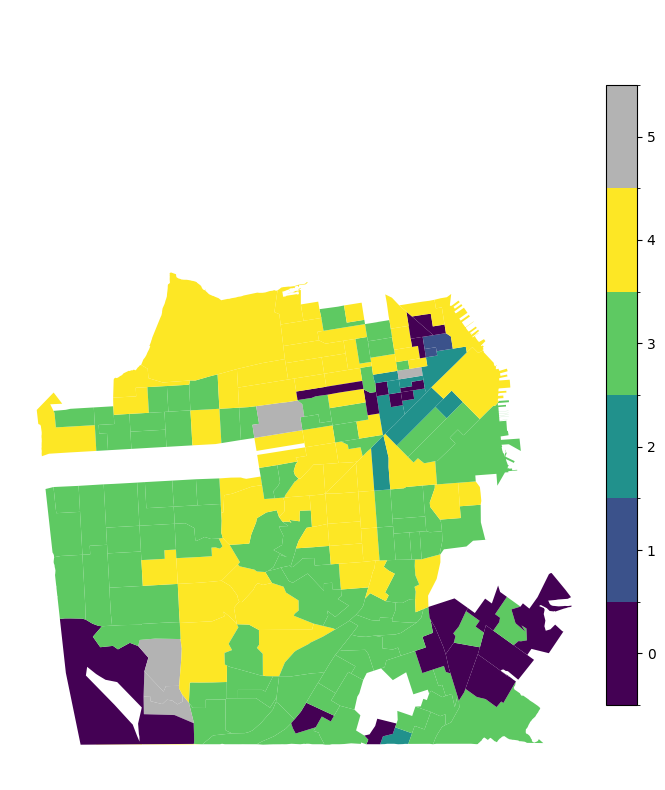

In [93]:
viridis = plt.get_cmap('viridis', 5)
viridis_colors = viridis(np.arange(5))
custom_colors = np.vstack([viridis_colors, [0.7, 0.7, 0.7, 1]])  # add gray
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set up a BoundaryNorm for discrete mapping (edges between each code)
bounds = np.arange(-0.5, 6.5, 1)  # 10 bins for values 0–9
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
p0 = gdf_bay.plot(column='Type_code_alternate',cmap=custom_cmap,norm=norm, ax=ax)

# Add colorbar with correct ticks and labels
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  # required for matplotlib < 3.1
cb0 = fig.colorbar(sm, ax=ax, ticks=np.arange(6), fraction=0.04, pad=0.01)
# cb0.set_label("Type_code")
# cb0.ax.set_yticklabels(list(alternate_mapping.keys()))  # Optional: use labels instead of numbers

ax.axis('off')
plt.show()


### Plot with folium

In [ ]:
# Ensure CRS is WGS84 (required by folium)
gdf_bay_wgs84 = gdf_bay.to_crs(epsg=4326)

# Factorize Typology to assign a unique color to each category
typologies = gdf_bay_wgs84['Typology'].fillna('Unknown')
codes, unique_typologies = pd.factorize(typologies)
colormap = cm.get_cmap('Set3', len(unique_typologies))  # can use 'tab10', 'Pastel1', etc.
color_dict = {typ: mcolors.to_hex(colormap(i)) for i, typ in enumerate(unique_typologies)}

# Set map center (centroid of all geometries)
center = gdf_bay_wgs84.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=10, tiles='cartodbpositron')

# Add each tract with color based on Typology
folium.GeoJson(
    gdf_bay_wgs84,
    name="Bay Area Tracts",
    style_function=lambda feature: {
        'fillColor': color_dict.get(feature['properties']['Typology'], '#999999'),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=['GEOID', 'Typology']),
).add_to(m)

# Add a legend manually
legend_html = '<div style="position: fixed; bottom: 20px; left: 20px; width: 200px; background: white; padding: 10px; font-size: 12px; border: 1px solid gray;">'
legend_html += '<b>Typology</b><br>'
for typ, color in color_dict.items():
    legend_html += f'<i style="background:{color};width:12px;height:12px;display:inline-block;margin-right:5px;"></i>{typ}<br>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Save or display
m.save("bay_area_typology_map.html")
m
